In [7]:
import torch

from utils import load_epsilon_net, load_image
from utils import load_epsilon_net
from sampling.dps import dps, dps_save
from sampling.dps_dpms import dps_dpms_save, dps_dpms
from sampling.dmps import dpms_save, dpms
from time import time
import os
import datetime

#timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

device = "cuda:0"
torch.set_default_device(device)
seed = 2024
torch.manual_seed(seed=seed) # for reproducibility


# load the image
img_path = "./hackathon_starter_kit/material/cat.jpeg"
x_origin = load_image(img_path, device)


# load the degradation operator
#path_operator = f"./hackathon_starter_kit/material/degradation_operators/sr16.pt"
#path_operator = f"./hackathon_starter_kit/material/degradation_operators/outpainting_half.pt"
path_operator = f"./hackathon_starter_kit/material/degradation_operators/inpainting_middle.pt"
degradation_operator = torch.load(path_operator, map_location=device)

# apply degradation operator
y = degradation_operator.H(x_origin[None])
y = y.squeeze(0)

sigma = 0.01
n_steps = 300


output_base= "./output/"



# add noise
y = y + sigma * torch.randn_like(y)

# define inverse problem
inverse_problem = (y, degradation_operator, sigma)

# load model
eps_net = load_epsilon_net("celebahq", n_steps, device)

# solve problem
initial_noise = torch.randn((1, 3, 256, 256), device=device)


#make output dir
dps_start = time()
reconstruction_dps = dps(initial_noise, inverse_problem, eps_net)
dps_end = time()
print(f"Time for DPS: {dps_end-dps_start}")

dpms_start = time()
reconstruction_dpms = dpms(initial_noise, inverse_problem, eps_net)
dpms_end = time()
print(f"Time for DPMS: {dpms_end-dpms_start}")

dps_dpms_start = time()
reconstruction_dps_dpms = dps_dpms(initial_noise, inverse_problem, eps_net, k=100)
dps_dpms_end = time()
print(f"Time for DPS_DPMS: {dps_dpms_end-dps_dpms_start}")
            

            



diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\Dolly\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\Dolly\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Time for DPS: 25.29541039466858
Time for DPMS: 14.993403673171997
Time for DPS_DPMS: 21.618926525115967


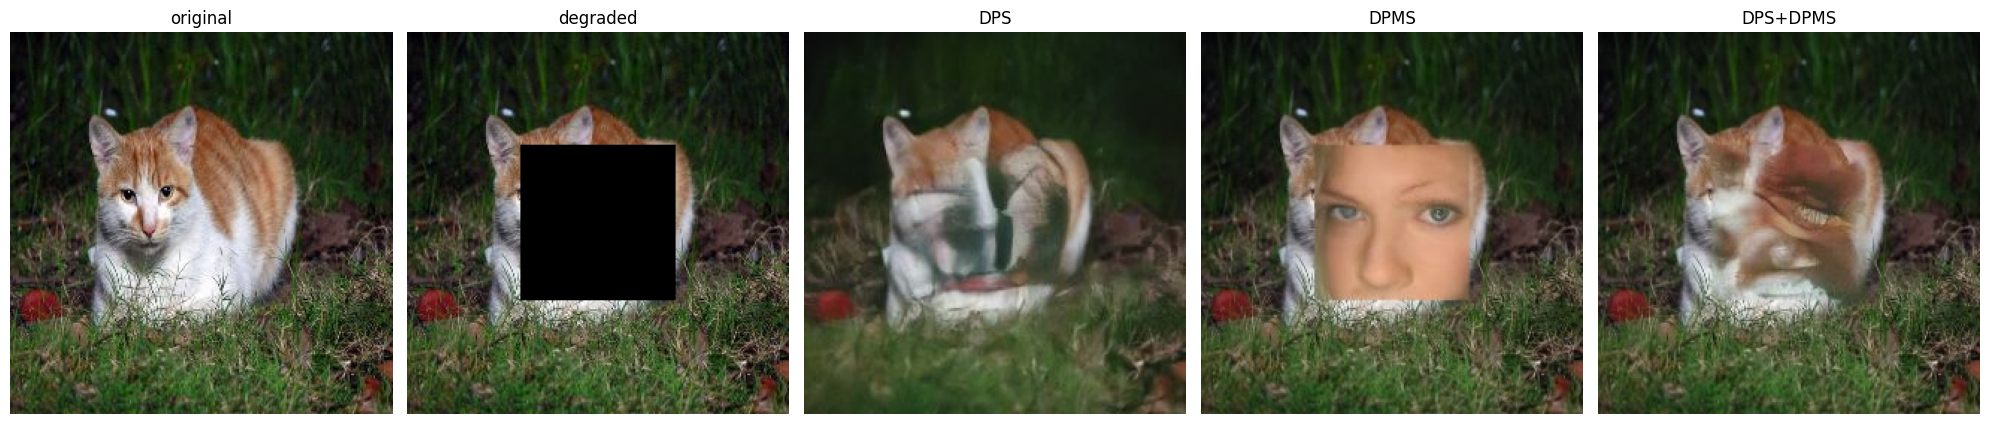

In [9]:
# plot results

# reshape y
y_reshaped =  -torch.ones(3 * 256 * 256, device=device)
y_reshaped[: y.shape[0]] = y
y_reshaped = degradation_operator.V(y_reshaped[None])
y_reshaped = y_reshaped.reshape(3, 256, 256)


# init figure
fig, axes = plt.subplots(1, 5, figsize=(20,20))

images = (x_origin, y_reshaped, reconstruction_dps, reconstruction_dpms, reconstruction_dps_dpms)
titles = ("original", "degraded", "DPS", "DPMS", "DPS+DPMS")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)
    ax.axis("off")

fig.tight_layout()

In [6]:
# plot results
import math
from utils import display_image
import matplotlib.pyplot as plt


# reshape y
n_channels = 3
n_pixel_per_channel = y.shape[0] // n_channels
hight = width = int(math.sqrt(n_pixel_per_channel))

y_reshaped = y.reshape(n_channels, hight, width)

# init figure
fig, axes = plt.subplots(1, 5, figsize=(20,20))

images = (x_origin, y_reshaped, reconstruction_dps, reconstruction_dpms, reconstruction_dps_dpms)
titles = ("original", "degraded", "DPS", "DMPS", "DPS+DMPS")

#fig, axes = plt.subplots(1, 3)

#images = (x_origin, y_reshaped, reconstruction_dps)
#titles = ("original", "degraded", "recon_dps")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)
    ax.axis("off")


fig.tight_layout()

RuntimeError: shape '[3, 233, 233]' is invalid for input of size 164160

In [10]:
from evaluation.perception import LPIPS

lpips =  LPIPS()
print(f"lpips_dps: {lpips.score(reconstruction_dps.clamp(-1, 1), x_origin)}")
print(f"lpips_dpms: {lpips.score(reconstruction_dpms.clamp(-1, 1), x_origin)}")
print(f"lpips_dps_dpms: {lpips.score(reconstruction_dps_dpms.clamp(-1, 1), x_origin)}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Dolly\.conda\envs\hackathon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dolly\.conda\envs\hackathon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Dolly\.conda\envs\hackathon\lib\site-packages\lpips\weights\v0.1\alex.pth
lpips_dps: 0.4934096932411194
lpips_dpms: 0.22802653908729553
lpips_dps_dpms: 0.1873331218957901
